In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa
import os
import sys
import argparse
from glob import glob
import xml.etree.ElementTree as ET
import cv2
import numpy as np

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'simingg' # username
os.environ['KAGGLE_KEY'] = 'f20436443b38c6021dd45fd29fab8531' # key

!kaggle datasets download -d andrewmvd/car-plate-detection

!unzip car-plate-detection.zip

 95% 193M/203M [00:01<00:00, 113MB/s]
100% 203M/203M [00:01<00:00, 131MB/s]
Archive:  car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.xml

In [ ]:
def read_annotation_data(xml_fn):
    file = open(xml_fn,'r')
    tree = ET.parse(file)
    root = tree.getroot()
    size = root.find('size')
    imw = int(size.find('width').text)
    imh = int(size.find('height').text)
    objects = []
    
    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymin = int(xmlbox.find('ymin').text)
        ymax = int(xmlbox.find('ymax').text)
        bb = [(xmin,ymin),(xmax,ymin),(xmax, ymax),(xmin,ymax)] # Top left, top right, bottom right, bottom left
        objects.append([cls,bb])

    return imw, imh, objects
    

In [ ]:
#### Define augmentation sequence ####
# This can be tweaked to create a huge variety of image augmentations.
# See https://github.com/aleju/imgaug for a list of augmentation techniques available.
seq1 = iaa.Sequential([
    iaa.Fliplr(0.5),                             # Horizontal flip 50% of images
    iaa.Crop(percent=(0, 0.20)),                 # Crop all images between 0% to 20%
    #iaa.GaussianBlur(sigma=(0, 1)),             # Add slight blur to images
    iaa.Multiply((0.7, 1.3), per_channel=0.2) # Slightly brighten, darken, or recolor images
##    iaa.Affine(
##        scale={"x": (0.8, 1.2), "y": (0.8,1.2)},                # Resize image
##        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # Translate image
##        rotate=(-5, 5),                                         # Rotate image
##        mode=ia.ALL, cval=(0,255)                               # Filling in extra pixels
##        )
    ])


In [ ]:
# Function for finding bounding box from keypoints
def kps_to_BB(kps,imgW,imgH):
    """
        Determine imgaug bounding box from imgaug keypoints
    """
    extend=1 # To make the bounding box a little bit bigger
    kpsx=[kp[0] for kp in kps]
    xmin=max(0,int(min(kpsx)-extend))
    xmax=min(imgW,int(max(kpsx)+extend))
    kpsy=[kp[1] for kp in kps]
    ymin=max(0,int(min(kpsy)-extend))
    ymax=min(imgH,int(max(kpsy)+extend))
    if xmin==xmax or ymin==ymax:
        return None
    else:
        #return ia.BoundingBox(x1=xmin,y1=ymin,x2=xmax,y2=ymax)
        return [(xmin, ymin),(xmax, ymax)]


In [ ]:
# Define XML annotation format for creating new XML files
xml_body_1="""<annotation>
        <folder>{FOLDER}</folder>
        <filename>{FILENAME}</filename>
        <path>{PATH}</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>{WIDTH}</width>
                <height>{HEIGHT}</height>
                <depth>3</depth>
        </size>
"""
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""
xml_body_2="""</annotation>        
"""

In [ ]:
# Function to create XML files
def create_xml(folder, image_path, xml_path, size, imBBs):

    # Get image size and filename
    imH, imW = size[0], size[1]
    image_fn = os.path.split(image_path)[-1]

    # Create XML file and write data
    with open(xml_path,'w') as f:
        f.write(xml_body_1.format(**{'FOLDER':folder, 'FILENAME':image_fn, 'PATH':image_path,
                                     'WIDTH':imW, 'HEIGHT':imH}))

        for bbox in imBBs:
            f.write(xml_object.format(**{'CLASS':bbox[0], 'XMIN':bbox[1][0], 'YMIN':bbox[1][1],
                                          'XMAX':bbox[1][2], 'YMAX':bbox[1][3]}))

        f.write(xml_body_2)

    return


In [ ]:
#get image files
classes = ['licence']
IMAGE_SIZE = 224
import glob
img_dir = "/content/images" # Enter Directory of all images 
xml_dir = "/content/annotations"
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes

In [ ]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    #for images whose license plates are cropped out
    xmin = 0
    ymin = 0
    xmax = 0
    ymax = 0
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [ ]:
IMG_EXTENSION = '.png'

cwd = os.getcwd()
for img_fn in files:
    # Open image, get shape and base filename
    original_img = cv2.imread(img_fn)
    imgH, imgW, _ = original_img.shape
    #print(imgH, imgW)
    base_img_fn = os.path.split(img_fn)[-1]
    base_fn = base_img_fn.replace(IMG_EXTENSION,'')
    
    # Read annotation data from image's corresponding XML file
    xml_fn = img_fn.replace(IMG_EXTENSION,'.xml')
    xml_fn = xml_fn.replace("/content/images", "/content/annotations")

    imgW_xml, imgH_xml, objects = read_annotation_data(xml_fn)

    if ((imgW_xml != imgW) or (imgH_xml != imgH)):
        print('Warning! Annotation data does not match image data for %s. Skipping image.' % img_fn)
        continue
    im_kps = []
    im_classes = []
    num_obj = len(objects)
    for obj in objects:
        im_classes.append(obj[0])
        im_kps.append(obj[1][0]) # Top left corner
        im_kps.append(obj[1][1]) # Top right corner
        im_kps.append(obj[1][2]) # Bottom right corner
        im_kps.append(obj[1][3]) # Bottom left corner

    # Define keypoints on image
    ia_kps = [ia.Keypoint(x=p[0], y=p[1]) for p in im_kps]
    original_kps = ia.KeypointsOnImage(ia_kps, shape=original_img.shape)

    # Create new augmented images, and save them in folder with annotation data
    for n in range(5):

        # Define new filenames
        img_aug_fn = base_fn + ('_aug%d' % (n+1)) + IMG_EXTENSION
        img_aug_path = os.path.join(cwd,img_dir,img_aug_fn)
        xml_aug_fn = img_aug_fn.replace(IMG_EXTENSION,'.xml')
        xml_aug_path = os.path.join(cwd,xml_dir,xml_aug_fn)

        # Augment image and keypoints.
        # First, copy original image and keypoints
        img = np.copy(original_img)
        kps = original_kps
        # Next, need to make sequence determinstic so it performs the same augmentation on image as it does on the keypoints
        seq1_det = seq1.to_deterministic()
        # Finally, run the image and keypoints through the augmentation sequence
        img_aug = seq1_det.augment_images([img])[0]
        kps_aug = seq1_det.augment_keypoints([kps])[0]
        imgH_aug, imgW_aug, _ = img_aug.shape

        # Extract augmented keypoints back into a list array, find BBs, and write annotation data to new file
        list_kps_aug = [(int(kp.x), int(kp.y)) for kp in kps_aug.keypoints]
        bboxes_aug = []
        bboxes_aug_data = []

        # Loop over every object, determine bounding boxes for new KPs, and save annotation data
        for i in range(num_obj):
            obj_aug_kps = list_kps_aug[i*4:(i*4+4)] # Augmented keypoints for each object
            obj_bb = kps_to_BB(obj_aug_kps,imgW_aug,imgH_aug) # Augmented bounding boxes for each object
            if obj_bb: # Sometimes the bbox coordinates are invalid and obj_bb is empty, so need to check if obj_bb valid
                bboxes_aug.append(obj_bb) # List of bounding boxes for each object
                xmin = int(obj_bb[0][0])
                ymin = int(obj_bb[0][1])
                xmax = int(obj_bb[1][0])
                ymax = int(obj_bb[1][1])
                coords = [xmin, ymin, xmax, ymax]
                label = im_classes[i]
                bboxes_aug_data.append([label, coords]) # List of bounding box data for each object (class name and box coordinates)

        # Save image and XML files to hard disk
        cv2.imwrite(img_aug_path,img_aug)
        create_xml(xml_dir, img_aug_fn, xml_aug_path, [imgH_aug,imgW_aug], bboxes_aug_data)


In [ ]:
path = '/content/annotations'
text_files = ['/content/annotations/'+f for f in sorted(os.listdir(path))] 

y=[] #contains the coorindates for images including new augmented images, sorted

for i in text_files:
  y.append(resizeannotation(i))

In [ ]:
img_dir = "/content/images" # re-read files with new aug images
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
img_fns=[] #images
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE)) #standardize to 224 img size
    img_fns.append(np.array(img)) #transform img to RGB(r,g,b) format

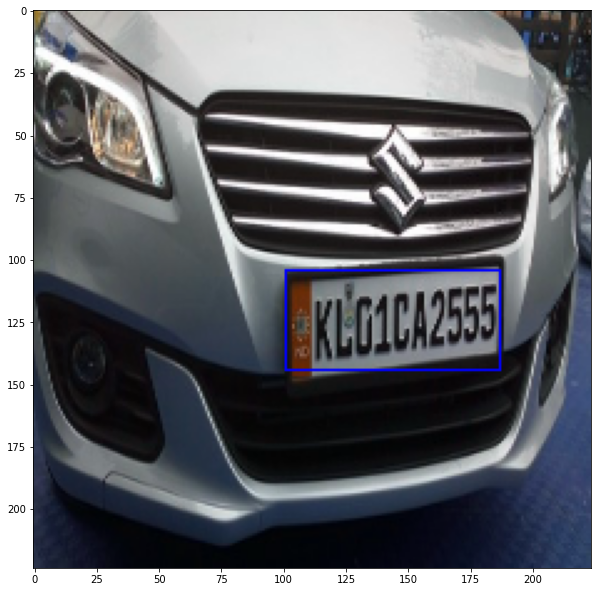

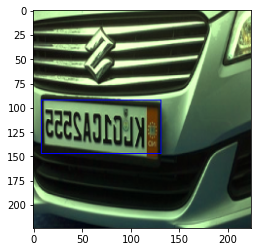

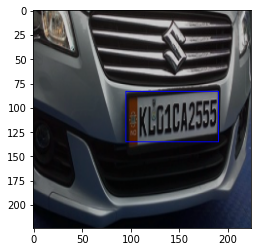

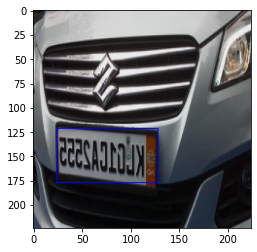

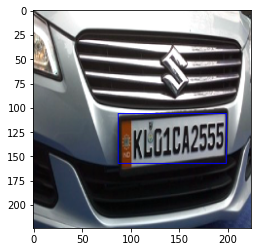

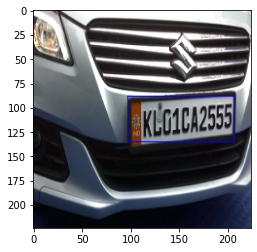

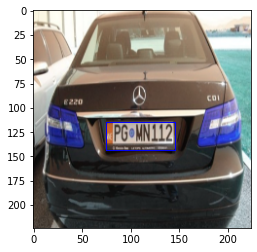

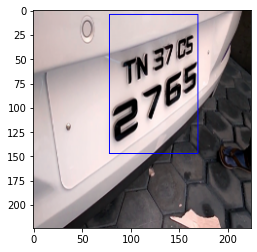

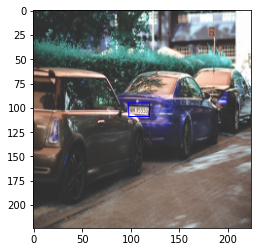

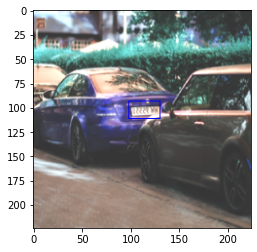

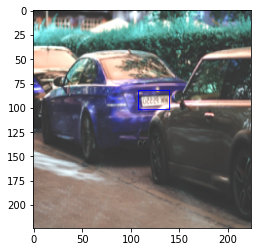

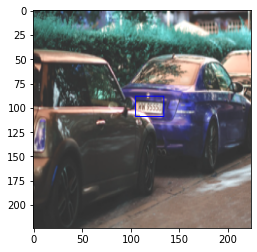

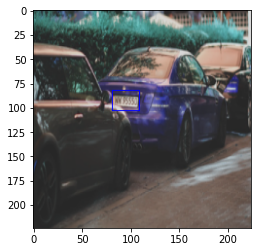

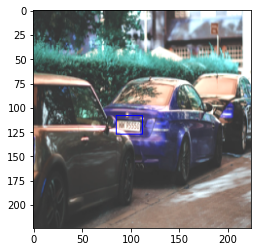

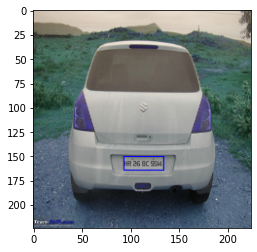

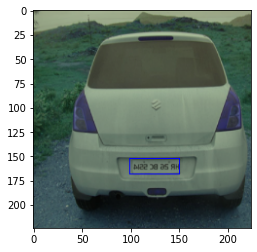

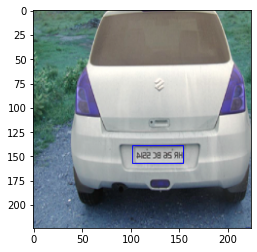

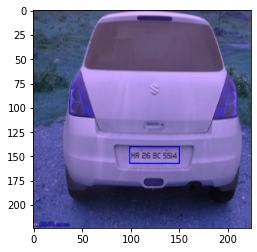

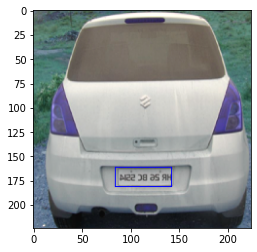

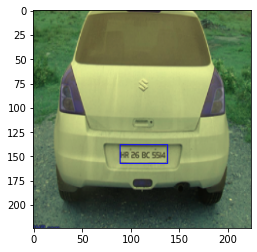

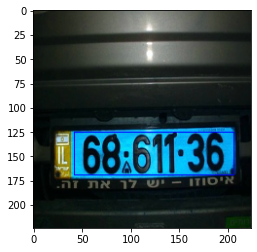

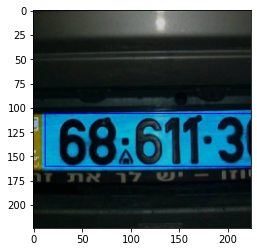

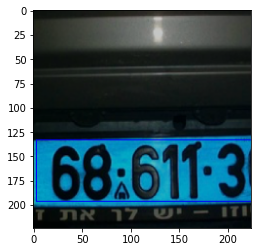

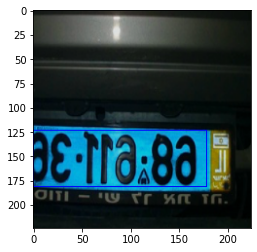

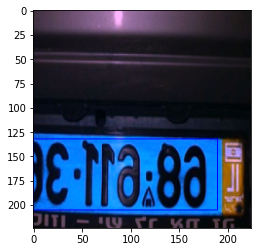

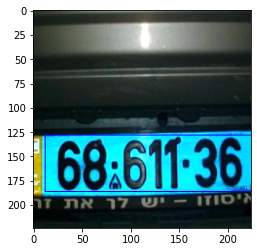

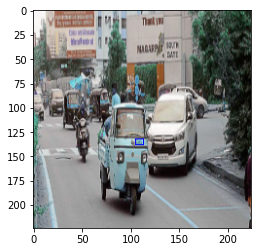

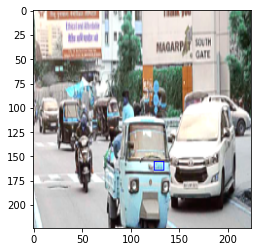

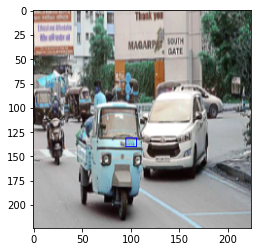

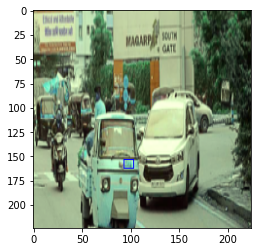

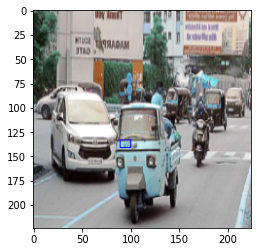

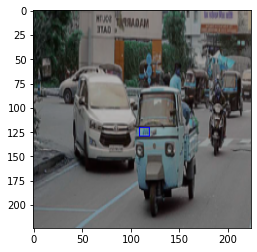

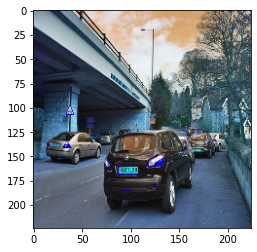

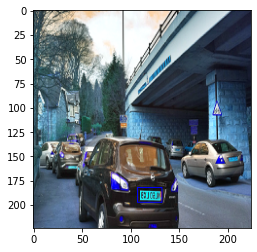

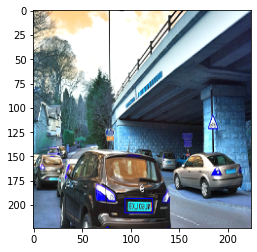

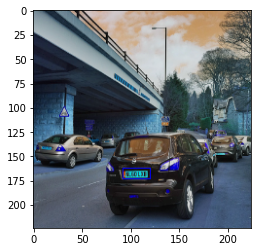

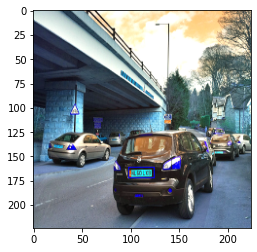

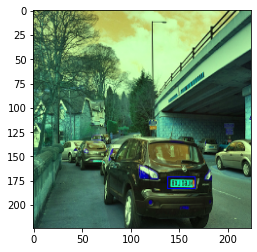

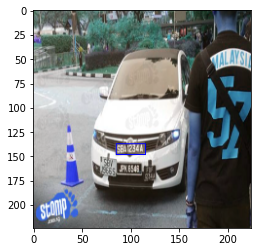

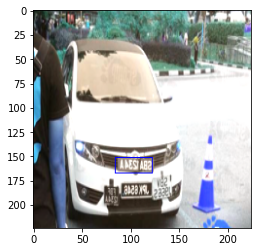

In [ ]:
from matplotlib import pyplot as plt
#test if BBox is accurate
plt.figure(figsize=(10,20))
for i in range(0,40) :
  image = cv2.rectangle(img_fns[i],(y[i][0],y[i][1]),(y[i][2],y[i][3]),(0, 0, 255))
  plt.imshow(image)
  plt.show()

In [ ]:
!zip -r /content/dataset1_images_aug.zip /content/images
!zip -r /content/dataset1_annotations_aug.zip /content/annotations

Streaming output truncated to the last 5000 lines.
  adding: content/images/Cars419.png (deflated 0%)
  adding: content/images/Cars61.png (deflated 0%)
  adding: content/images/Cars307_aug4.png (deflated 1%)
  adding: content/images/Cars263.png (deflated 0%)
  adding: content/images/Cars36_aug3.png (deflated 1%)
  adding: content/images/Cars46.png (deflated 0%)
  adding: content/images/Cars72_aug1.png (deflated 1%)
  adding: content/images/Cars310_aug4.png (deflated 1%)
  adding: content/images/Cars195.png (deflated 0%)
  adding: content/images/Cars268_aug3.png (deflated 1%)
  adding: content/images/Cars402.png (deflated 0%)
  adding: content/images/Cars199_aug2.png (deflated 2%)
  adding: content/images/Cars192_aug2.png (deflated 4%)
  adding: content/images/Cars118_aug5.png (deflated 1%)
  adding: content/images/Cars129.png (deflated 0%)
  adding: content/images/Cars395_aug3.png (deflated 0%)
  adding: content/images/Cars144_aug3.png (deflated 1%)
  adding: content/images/Cars348_aug

In [ ]:
#transform to array
X=np.array(img_fns)
y=np.array(y) #coordinates
#Renormalisation
X = X / 255
y = y / 255

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #split to 80,20 rule
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [ ]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg19 import VGG19

In [ ]:
# Create the model
model = Sequential()
model.add(VGG19(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 23,260,804
Trainable params: 3,236,420
Non-

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)

Epoch 1/20
59/59 [==============================] - 66s 476ms/step - loss: 0.0562 - accuracy: 0.5856 - val_loss: 0.0162 - val_accuracy: 0.7115
Epoch 2/20
59/59 [==============================] - 18s 305ms/step - loss: 0.0107 - accuracy: 0.7898 - val_loss: 0.0167 - val_accuracy: 0.7596
Epoch 3/20
59/59 [==============================] - 18s 305ms/step - loss: 0.0056 - accuracy: 0.8294 - val_loss: 0.0079 - val_accuracy: 0.8365
Epoch 4/20
59/59 [==============================] - 18s 305ms/step - loss: 0.0034 - accuracy: 0.8717 - val_loss: 0.0069 - val_accuracy: 0.8221
Epoch 5/20
59/59 [==============================] - 18s 305ms/step - loss: 0.0020 - accuracy: 0.8877 - val_loss: 0.0068 - val_accuracy: 0.8269
Epoch 6/20
59/59 [==============================] - 18s 305ms/step - loss: 0.0017 - accuracy: 0.9064 - val_loss: 0.0070 - val_accuracy: 0.8462
Epoch 7/20
59/59 [==============================] - 18s 305ms/step - loss: 0.0013 - accuracy: 0.9150 - val_loss: 0.0051 - val_accuracy: 0.8798

In [ ]:
model.save('model.h5', overwrite=True) 

In [ ]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 91.92%


In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

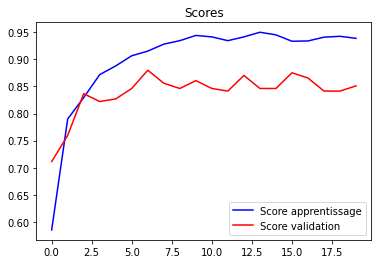

In [ ]:
plot_scores(train)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

100/100 [==============================] - 16s 134ms/step - loss: 0.0046 - accuracy: 0.9192
Test results 
 Loss: 0.00463624345138669 
 Accuracy 0.9192307591438293


In [ ]:
 y_cnn = model.predict(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

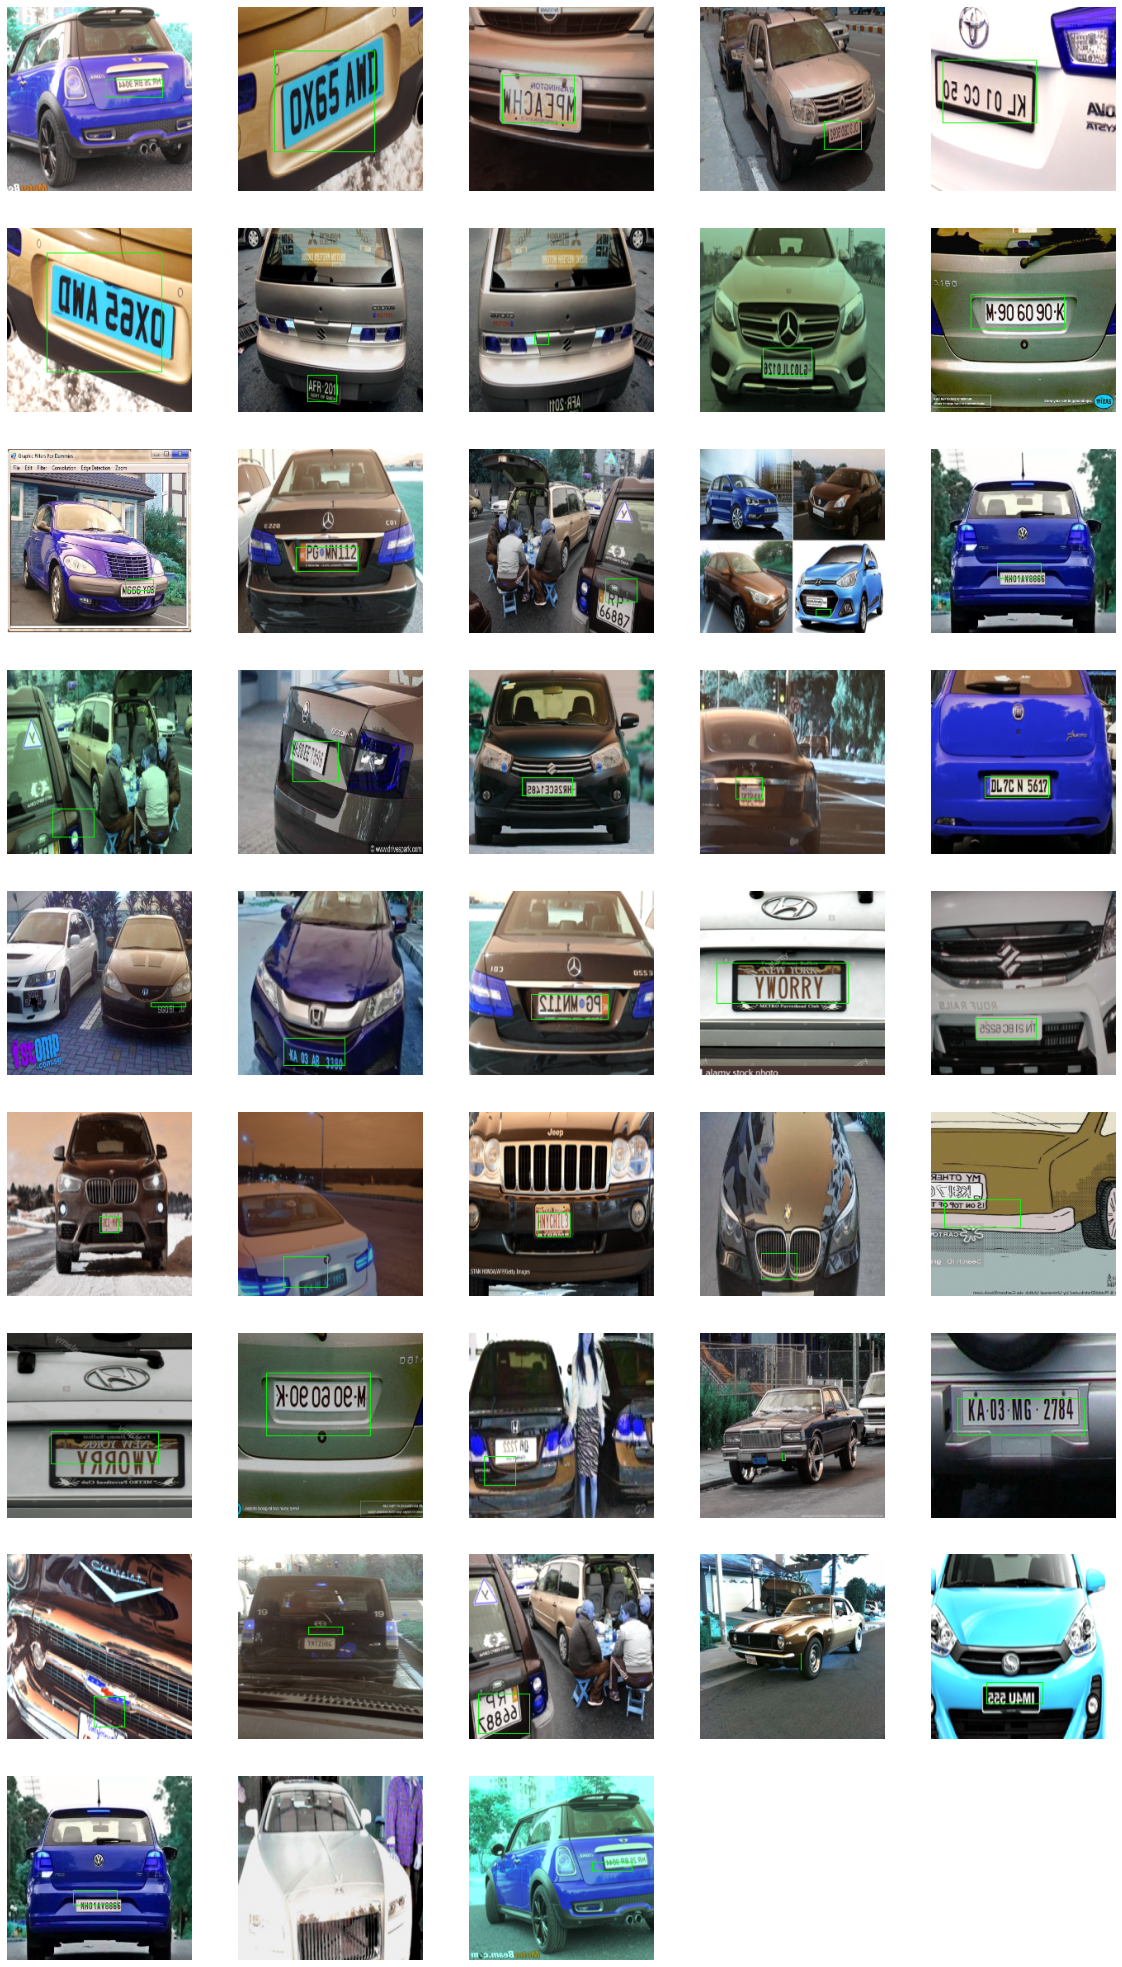

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)